# Implement models in Stan
Implement each of the models below using Stan and produce the results or plots requested for each model. You have seen each of these models before in class.

The goal of this exercise is to learn how to implement different types of parameters, likelihood
functions, and prior distributions using Stan. Stan always generates samples for estimating
posterior distributions, while we used conjugate distributions in class. Check that your results from
Stan’s samples match the results we computed in class.

**1. Exponential likelihood with a gamma prior** Call center data set —  Estimate the number of calls per minute for the 13th hour of the call center data set.

Results to compute:
- Posterior 98% confidence interval over λ (check that it matches results in the solution notebook below)
- Histogram of posterior λ samples

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import pystan as stan

### Importing and Visualizing the Data

In [2]:
waiting_times_day = np.loadtxt('call_center.csv')

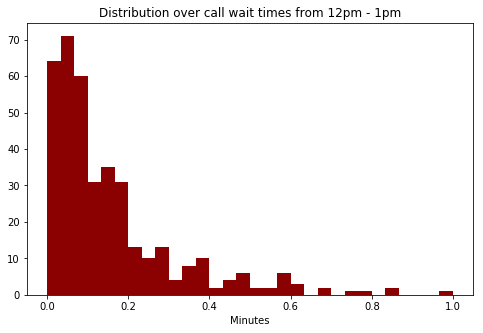

In [3]:
# Split the data into 24 separate series, one for each hour of the day
current_time = 0
waiting_times_per_hour = [[] for _ in range(24)]  # Make 24 empty lists, one per hour
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

#distribution over the 13th hour
plt.figure(figsize=(8,5))

plt.hist(waiting_times_per_hour[13], color='darkred', bins=30)
plt.xlabel("Minutes")
plt.title("Distribution over call wait times from 12pm - 1pm")
plt.show()

## Using PyStan

In [4]:
call_center_data = {
    'hour13': {
        'alpha': 1,     # fixed prior hyperparameters for the
        'beta': 0.25,   # gamma distribution
        'calls': waiting_times_per_hour[13]}}  # wait times per hour

print(len(waiting_times_per_hour[13]))

382


In [5]:
stan_code_call_center = """

data {  
    real<lower=0> alpha;      //prior hyperparameter
    real<lower=0> beta;       //prior hyperparameter
    real<lower=0> calls[382];  //wait times per hour - array of 382
}

parameters {
    real<lower=0> lambda;     // parameter of the exponential posterior
    
}

model {
    lambda ~ gamma(alpha, beta);  // prior over p
    calls ~ exponential(lambda);  // likelihood function
}

"""

In [6]:
stan_model = stan.StanModel(model_code=stan_code_call_center)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a3f0cc223a4da1aa086d6ef3130758c0 NOW.


In [7]:
stan_results = stan_model.sampling(data=call_center_data['hour13'])

In [8]:
print(stan_results.stansummary(pars=['lambda'], probs=[0.01, 0.99]))
 
    

Inference for Stan model: anon_model_a3f0cc223a4da1aa086d6ef3130758c0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd     1%    99%  n_eff   Rhat
lambda   6.34  8.2e-3   0.33   5.59   7.16   1624    1.0

Samples were drawn using NUTS at Fri Oct 18 17:34:51 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Posterior 98% confidence interval for λ: [5.59309945 7.16448686]


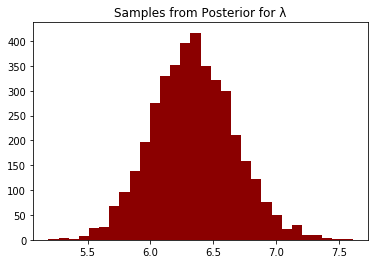

In [9]:
posterior_samples = stan_results.extract()
plt.hist(posterior_samples['lambda'], color='darkred', bins=30)
plt.title('Samples from Posterior for λ')
print(
    "Posterior 98% confidence interval for λ:",
    np.percentile(posterior_samples['lambda'], [1.0, 99.0]))
plt.show()

**2. Normal likelihood with normal-inverse-gamma prior**

Results to compute:
- 95% posterior confidence intervals for the mean μ and variance σ of the data.
- Take 10 samples from your posterior over μ and σ and plot the normal distributions corresponding to them. 

In [10]:
data = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628,
                 -0.692265320368236, 3.04473513808788, 3.10721270732507,
                 3.42982225852764, 3.12153903971176, 3.60532628639808,
                 2.46561737557325, 1.64059465916131, 2.4621623937158,
                 2.76744495617481, 2.11580054750407, 5.14077208608354,
                 4.90288499104252, 1.43357579078348, 4.78997817363558,
                 1.93633438207439, 2.43698838097178, 3.95389148701877,
                 2.4242295507716, 2.90256268679023, 2.90931728045901,
                 0.658072819386888, 3.05946763895983, 3.42615331539605,
                 2.68842833004417, 2.35850130765166, 2.20014998540933,
                 4.73846511350084, 4.19839721414451, 2.11805510171691,
                 -0.572742936038015, 0.389413982010623, 3.87846130744249,
                 1.34057656890858, 0.7235748351719, 5.11042369840174,
                 4.00747556696571, 3.18080956726965, 3.24677964069676,
                 5.1154659863626, 1.80276616697155, 0.305877679021404,
                 -0.449168307882718, 4.63705561194774, 1.37783714058301,
                 4.9608149859515, 6.7764195802069, 1.75515522922399,
                 7.04457337435215, 0.625185284955128, 2.25130734369064,
                 2.19770178119255, 2.16858257249432, 6.25367644481438,
                 0.116081323476489, 2.06315857864341, 1.82409781471718,
                 5.15226741230987, 2.03408231293173, -1.12450854337596,
                 5.03511270642234, 2.03841989653263, 5.80911741751597,
                 2.31718128783245, 4.97575010580997, 3.34262752222776,
                 -0.786983904253601, 0.777362359850013, 0.975825009321195,
                 3.76354577515958, 7.27215002907876, 1.35404089480189,
                 3.76567940257157, 3.48573993343334, 1.85976988586156,
                 1.93567061960716, 5.31071812003942, 2.96832987672751,
                 3.32378908637275, 2.61631960054551, 5.80897964052825,
                 4.95215217171488, 1.32036772796131, 3.79932542233371,
                 3.08108492766309, 2.6734110081666, -0.14251851138521,
                 2.48744375588965, 3.98463042123415, 6.32781680028,
                 4.0029172024315, 4.23210369459457, 1.71412938967325,
                 5.16492114963802, 2.53409673107906, 4.77346963973334,
                 3.34088878725551, 4.77681472750664, 3.81135755590976,
                 1.14054269983137, 1.42057452397702, 0.132142311125433,
                 7.12577254064672, 4.85422012781764, 4.15745720676399,
                 4.48763147363348, 1.56060322283629, 2.64821761542887,
                 1.26655351354548, 4.48497722937931, 4.3286302403783,
                 4.26157679512625, 4.0597558651364, 5.14051109132496,
                 2.5660348362221, 1.10764013818617, 0.386889523012303,
                 3.54150473246237, 3.57480214382351, 1.95150869584847,
                 2.70688970563118, 2.47971849820016, 6.50838037000679,
                 4.01511556826974, 1.11562740835344, 5.02637639472439,
                 4.38184491686864, 5.60423144047386, 2.40067408379298,
                 5.7849941378344, 2.37225791084559, 6.86031465910273,
                 4.09214858239736, 6.85994063692621, 3.62202415158781,
                 -1.11220646958158, 3.73920971696866, 3.24533871512216,
                 1.28724203643002, 0.291152541773164, 0.368630935755111,
                 6.71607270510525, 5.42278455200833, 5.35188416119281,
                 2.305874586163, -1.85878097203032, 2.69877382351447,
                 4.84121860550417, 4.40973060799391, 5.04399320650774,
                 2.68632252661298, 6.06531610659912, 3.11881325011993,
                 3.45532087005125, 3.08442259840346, 4.43564424136733,
                 2.84252623135804, 1.50536798885106, 1.48868622407603,
                 2.07322837615663, 2.5476910210998, 5.66941808257884,
                 2.16731067416426, 2.49843958833905, 3.94586413879977,
                 0.316433764679541, -0.608937441815983, 2.5943436558557,
                 1.05516869528337, 2.1447601332725, 6.65846634141906,
                 2.1771555267834, 5.23953812029442, 3.53629759842647,
                 6.03263538017003, 3.85739159396599, 5.95093453004638,
                 1.12856987160476, 3.5559912886093, 2.21974864244489,
                 3.38471394882135, -1.90805399279409, 3.5113699258973,
                 4.49319955412346, 5.10507952638867, 1.08277895384184,
                 4.58403638422759, 1.37304994426824, 4.17566975753523,
                 3.36454182510378, 0.177136582644021, 2.91337423388405,
                 3.22796455457526, 2.80124198378441, 1.95189718582788,
                 3.37659263896246, -1.6463045238231])

In [11]:
print(min(data), max(data))

-1.90805399279409 7.27215002907876


In [12]:
normal_data = {
    'the_data': {
        'mu': 0,      #prior hyperparameters  
        'nu': 0.054, 
        'alpha': 1.12,
        'beta': 0.4,
        'norm_data': list(data)}}  #normally distributed "data"

In [13]:
stan_code_normal_data = """

data { 
    real<lower=-1000> mu;           //prior hyperparameter
    real<lower=0> nu;               //prior hyperparameter
    real<lower=0> alpha;            //prior hyperparameter
    real<lower=0> beta;             //prior hyperparameter
    real<lower=-2.0, upper=8.0> norm_data[200];   //normally distributed "data"
}

parameters {
    real<lower=0> mean_post;     // parameters of the posterior 
    real<lower=0> var_post;      
    
}

model {
    mean_post ~ normal(mu, 1/nu);                //prior
    var_post ~ inv_gamma(alpha, beta);
    
    norm_data ~ normal(mean_post, sqrt(var_post));     //normal likelihood
}

"""

In [14]:
stan_model_norm = stan.StanModel(model_code=stan_code_normal_data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1a1eb5983b259d04b8adf22bac0e486 NOW.


In [15]:
stan_results_norm = stan_model_norm.sampling(data=normal_data['the_data'])

In [16]:
print(stan_results_norm.stansummary(pars=['mean_post', 'var_post'], probs=[0.025, 0.975]))


Inference for Stan model: anon_model_e1a1eb5983b259d04b8adf22bac0e486.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
mean_post   3.07  2.3e-3   0.14    2.8   3.33   3530    1.0
var_post    3.63  6.8e-3   0.36   2.99    4.4   2842    1.0

Samples were drawn using NUTS at Fri Oct 18 17:35:58 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


4000


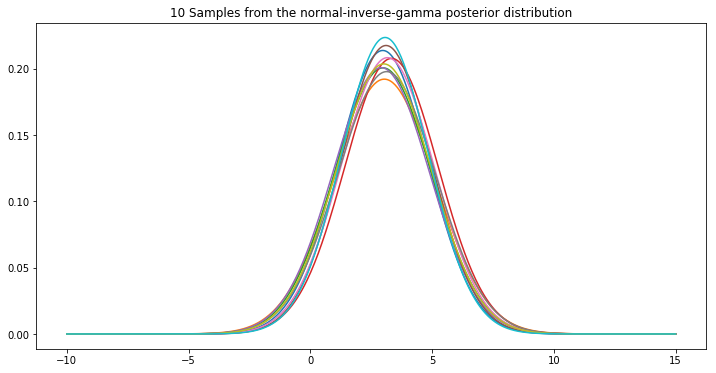

In [17]:
#this gives us 4000 samples, we'll plot the first 10
posterior_samples = stan_results_norm.extract()
print(np.size(posterior_samples['mean_post']))

# Plot the normal distributions corresponding to the samples
plt.figure(figsize=(12, 6))
x = np.linspace(-10, 15, 500)

for i in range(10):
    y = stats.norm.pdf(x, loc=posterior_samples['mean_post'][i], scale=np.sqrt(posterior_samples['var_post'][i]))
    plt.plot(x, y)
plt.title('10 Samples from the normal-inverse-gamma posterior distribution')
plt.show()

**3. Log-normal HRTEM data** Normal likelihood log-transformed data and using a normal-inverse-gamma prior.

Results to compute:
- 95% posterior confidence intervals for the μ and variance σ of the log-transformed data.
- Take 10 samples from your posterior over μ and σ and plot the log-normal distributions corresponding to them. See Task 5 in the solutions below — you should produce a plot similar the one you find there, but with 10 pdfs rather than one.

In [18]:
hrtem_data = np.loadtxt('hrtem.csv')

In [19]:
print(hrtem_data[:10])
print(np.size(hrtem_data))
print(min(hrtem_data), max(hrtem_data))

[1.86113123 1.25956995 1.05182743 1.70114031 1.69572557 1.57366262
 1.44589366 1.22153038 1.7669232  1.78990843]
500
1.05182743421756 28.9425775960553


In [20]:
hrtem_data_dict = {
    'particle_data': {
        'mu': 2.3,      #prior hyperparameters  
        'nu': 0.1, 
        'alpha': 2.0,
        'beta': 5.0,
        'nonlog_data': list(hrtem_data)}}  #normally distributed "data"


# call_center_data = {
#     'hour13': {
#         'alpha': 1,     # fixed prior hyperparameters for the
#         'beta': 0.25,   # gamma distribution
#         'calls': waiting_times_per_hour[13]}}  # wait times per hour

In [21]:
stan_code_hrtem = """

data { 
    real<lower=-1000> mu;           //prior hyperparameter
    real<lower=0> nu;               //prior hyperparameter
    real<lower=0> alpha;            //prior hyperparameter
    real<lower=0> beta;             //prior hyperparameter
    real<lower=0, upper=30> nonlog_data[500]; //original data
}

transformed data {
    real log_data[500];         //log transformed data
    for (i in 1:500){
        log_data[i] <- log(nonlog_data[i]);
    }

}

parameters {
    real<lower=0> mean_post;     // parameters of the posterior 
    real<lower=0> var_post;      
    
}

model {
    mean_post ~ normal(mu, 1/nu);                //prior
    var_post ~ inv_gamma(alpha, beta);
    
    log_data ~ normal(mean_post, sqrt(var_post));     //normal likelihood
}

"""

In [22]:
stan_model_hrtem = stan.StanModel(model_code=stan_code_hrtem)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f679900bdd4ac4420dfda3c658ef5a0b NOW.


In [23]:
stan_results_hrtem = stan_model_hrtem.sampling(data=hrtem_data_dict['particle_data'])
print(stan_results_hrtem.stansummary(pars=['mean_post', 'var_post'], probs=[0.025, 0.975]))



Inference for Stan model: anon_model_f679900bdd4ac4420dfda3c658ef5a0b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
mean_post   1.89  5.2e-4   0.03   1.83   1.95   3496    1.0
var_post     0.5  5.4e-4   0.03   0.44   0.57   3536    1.0

Samples were drawn using NUTS at Fri Oct 18 17:37:00 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


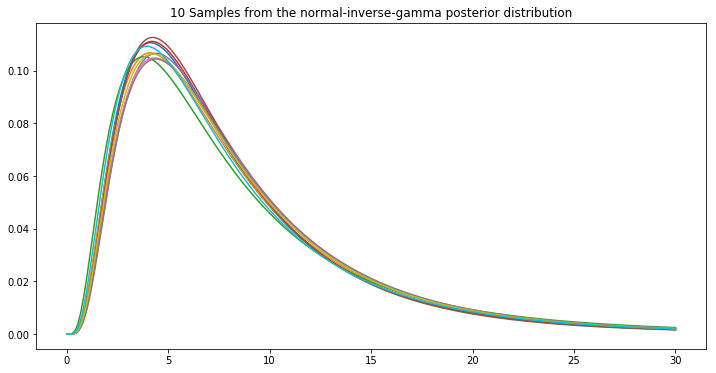

In [28]:
posterior_samples = stan_results_hrtem.extract()

# Plot the normal distributions corresponding to the samples
plt.figure(figsize=(12, 6))
x = np.linspace(0, 30, 500)

for i in range(10):
    y = stats.lognorm.pdf(x, s=np.sqrt(posterior_samples['var_post'][i]),
                          scale=np.exp(posterior_samples['mean_post'][i]))
    plt.plot(x, y)
plt.title('10 Samples from the normal-inverse-gamma posterior distribution')
plt.show()